In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from table_reader import TableReader
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LogisticRegression

Hey folks, I'm just trying out a proof-of-concept jupyter notebook that uses our data retrieval code.

I got sick of working with environment variables so I switched to a new method to store our DB password:
    1. Create a file called config.json in the project root.
    2. Inside, config.json should look like this:
    {
        "database_url":"database_url_goes_here"
    }

TableReader's other vector methods are geodata_vector() and reviews_vector(). Be sure to call close() when you're done so it terminates the connection to the DB.

In [25]:
tr = TableReader()
prop = tr.properties_vector(include_amenitites=True)
geo = tr.geodata_vector()
ratings = tr.reviews_vector()[['listingID','num_reviews', 'rating']]
tr.close()

In [26]:
df = pd.merge(geo,
            prop,
            on='listingID')

In [27]:
df = pd.merge(df, ratings, on='listingID', how='left')

In [28]:
df.dropna(subset=['zipcode'], inplace=True)
df = df[df['num_reviews'] > 10]

In [29]:
df.head()

,listingID,zipcode,latitude,longitude,"Brightwood Park, Crestwood, Petworth","Brookland, Brentwood, Langdon","Capitol Hill, Lincoln Park","Capitol View, Marshall Heights, Benning Heights","Cathedral Heights, McLean Gardens, Glover Park","Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace",...,Dishwasher,Shampoo,Bathtub,Wifi,Keypad,Breakfast,Dishes and silverware,Laptop friendly workspace,num_reviews,rating
1,3344,20005.0,38.90126,-77.02857,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,11,100.0
2,3662,20020.0,38.86193,-76.98963,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,36,94.0
3,3686,20020.0,38.86314,-76.98836,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,69,91.0
5,4197,20003.0,38.88791,-76.99668,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,39,97.0
6,4529,20019.0,38.90645,-76.94305,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,99,93.0


In [30]:
features = df[df.columns.drop(['price', 'listingID'])]
label = df['price']

## Feature Selection

In [31]:
model = ElasticNet()
esfm = SelectFromModel(model)
esfm.fit(features, label)
print(list(features.iloc[:, esfm.get_support(indices=True)]))

['Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'beds', 'Guest suite', 'Entire home/apt', 'Private room', 'Shared room', 'Paid parking off premises', 'Internet', 'Free street parking', '24-hour check-in', 'Elevator', 'Self check-in', 'Indoor fireplace', 'Lock on bedroom door', 'Free parking on premises', 'Dryer', 'TV', 'First aid kit', 'Cable TV', 'Gym', 'Family/kid friendly', 'Washer', 'rating']


In [32]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['zipcode', 'Capitol Hill, Lincoln Park', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Georgetown, Burleith/Hillandale', 'accomodates', 'bathrooms', 'bedrooms', 'Entire home/apt', 'Internet', 'Free street parking', '24-hour check-in', 'Elevator', 'Indoor fireplace', 'Lock on bedroom door', 'Free parking on premises', 'Dryer', 'Cable TV', 'Gym', 'Family/kid friendly', 'num_reviews', 'rating']


In [33]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(features, label)
print(list(features.iloc[:, sfm.get_support(indices=True)]))

['latitude', 'longitude', 'Capitol Hill, Lincoln Park', 'Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace', 'Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View', 'Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street', 'Dupont Circle, Connecticut Avenue/K Street', 'Edgewood, Bloomingdale, Truxton Circle, Eckington', 'Georgetown, Burleith/Hillandale', 'Howard University, Le Droit Park, Cardozo/Shaw', 'Ivy City, Arboretum, Trinidad, Carver Langston', 'Kalorama Heights, Adams Morgan, Lanier Heights', 'Near Southeast, Navy Yard', 'North Cleveland Park, Forest Hills, Van Ness', 'Shaw, Logan Circle', 'Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point', 'Union Station, Stanton Park, Kingman Park', 'West End, Foggy Bottom, GWU', 'bathrooms', 'bedrooms', 'Apartment', 'Guest suite', 'Serviced apartment', 'Entire home/apt', 'Shared room']


In [34]:
elastic_data = df[list(features.iloc[:, esfm.get_support(indices=True)])]

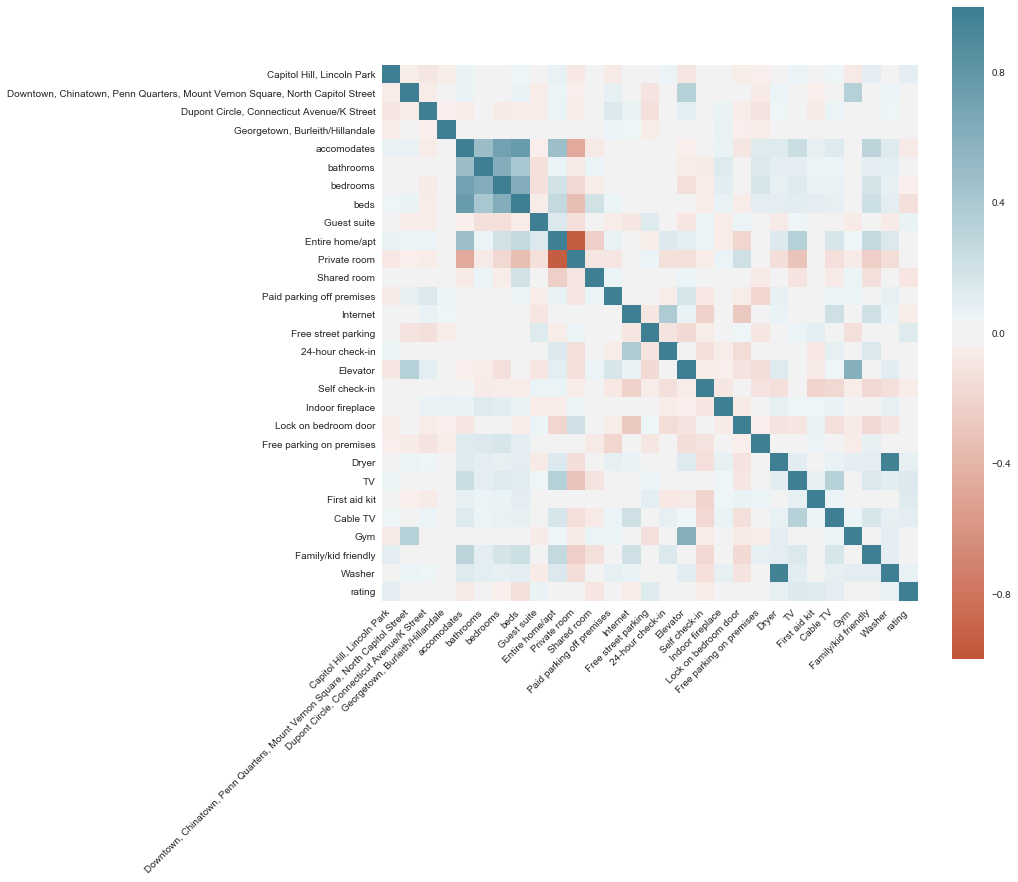

In [35]:
corr = elastic_data.corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Chi-squared (chi²) statistical test for non-negative features to select 20 of the best features from the Mobile Price Range Prediction Dataset.

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#drop geo data in the feature selection because Chi2 only works for non-negative features
featureswithoutgeo = features[features.columns.drop(['longitude'])]

#apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k=20)
fit = bestfeatures.fit(featureswithoutgeo,label)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(featureswithoutgeo.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(20,'Score'))  #print 20 best features

                                                 Specs         Score
104                                        num_reviews  27183.566869
30                                         accomodates   2473.582634
42                                         Shared room   2128.129306
33                                                beds   1618.942310
41                                        Private room   1342.079583
38                                  Serviced apartment   1282.085411
32                                            bedrooms   1052.020329
10   Downtown, Chinatown, Penn Quarters, Mount Vern...    827.206153
5      Capitol View, Marshall Heights, Benning Heights    771.429540
70                                                Pool    671.943591
88                                                 Gym    660.933201
40                                     Entire home/apt    650.559290
28                         West End, Foggy Bottom, GWU    630.330009
62                               W

Feature Importance

Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top 20 features for the dataset.

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.0320273  0.05210409 0.05275423 0.00517685 0.0032191  0.00850181
 0.00160484 0.00182575 0.0017603  0.00826498 0.0013201  0.00395393
 0.00714652 0.01029729 0.00179771 0.00466887 0.00567904 0.00440999
 0.00405308 0.00191487 0.00095629 0.0008507  0.00169542 0.00875579
 0.00230655 0.00135196 0.0026653  0.00202905 0.01126937 0.00261433
 0.00154689 0.03491758 0.01720534 0.02185109 0.03027864 0.01191523
 0.00690474 0.00523115 0.00950492 0.00121634 0.0109695  0.00368506
 0.00362467 0.00189247 0.01070292 0.01937451 0.01263063 0.02032943
 0.00466914 0.00521536 0.01093949 0.00459343 0.00834491 0.00726607
 0.01365558 0.00287646 0.00284794 0.01256968 0.00208637 0.00223212
 0.00333204 0.00251932 0.00588067 0.00333621 0.00136262 0.00894411
 0.01336068 0.0015608  0.00761837 0.00208608 0.00455633 0.00428821
 0.01608499 0.01676173 0.01908235 0.00052355 0.01803367 0.00913902
 0.01838751 0.01296679 0.00962258 0.00362188 0.00687632 0.00111733
 0.00749003 0.0160302  0.00360356 0.02317803 0.01944788 0.0064

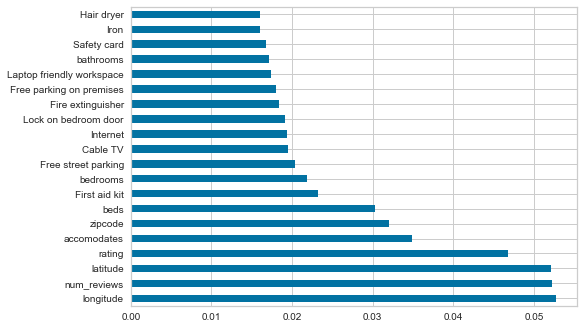

longitude                    0.052754
num_reviews                  0.052221
latitude                     0.052104
rating                       0.046814
accomodates                  0.034918
zipcode                      0.032027
beds                         0.030279
First aid kit                0.023178
bedrooms                     0.021851
Free street parking          0.020329
Cable TV                     0.019448
Internet                     0.019375
Lock on bedroom door         0.019082
Fire extinguisher            0.018388
Free parking on premises     0.018034
Laptop friendly workspace    0.017422
bathrooms                    0.017205
Safety card                  0.016762
Iron                         0.016085
Hair dryer                   0.016030
dtype: float64


In [37]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(features,label)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()
print(feat_importances.nlargest(20))

# Model Selection

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = tts(features, label, test_size=0.2)


In [39]:
regr = LinearRegression()
regr.fit(X_train,y_train)
print(mean_squared_error(y_test, regr.predict(X_test)))
print(regr.score(X_test,y_test))

1840.9428371217143
0.6196790725196695


In [40]:
import numpy as np

# try 200 different alphas between -10 and -2
n_alphas = 200
alphas = np.logspace(-10, -2, n_alphas)

model_ridge = RidgeCV(alphas=alphas)
model_ridge.fit(X_train, y_train)

#which alpha did it pick?
print(model_ridge.alpha_)


0.01


In [41]:
ridge = Ridge(alpha=0.01)
model_ridge.fit(X_train, y_train)
print(mean_squared_error(y_test, model_ridge.predict(X_test)))
print(model_ridge.score(X_test, y_test))

1840.8800068231233
0.6196920526497159


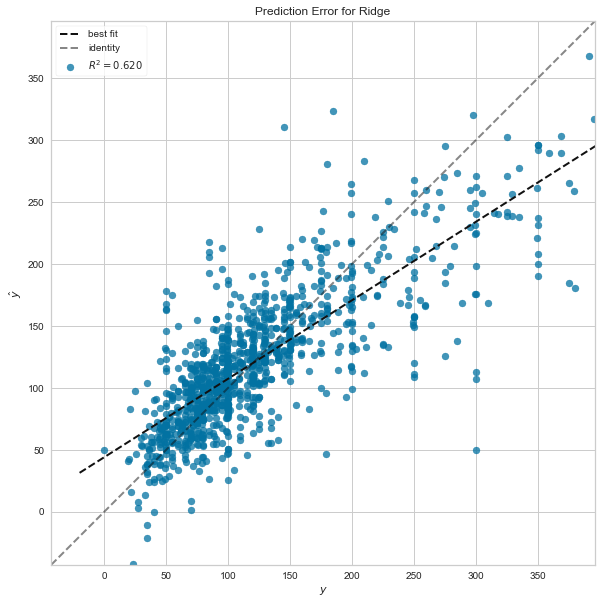

In [42]:
from yellowbrick.regressor import PredictionError

model = Ridge(alpha=0.01)
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

In [43]:
from sklearn.model_selection import GridSearchCV


lasso = Lasso(random_state=0)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_params = [{'alpha': alphas}]
n_folds = 12

grid = GridSearchCV(
    lasso, tuned_params, cv=n_folds
)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)


In [44]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
lasso.score(X_test, y_test)

1841.0458548180598


0.6196577900631852

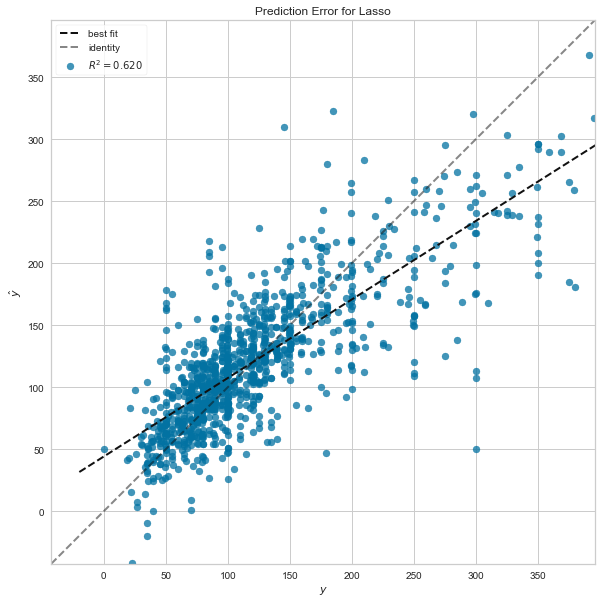

In [45]:
model = Lasso(alpha=0.001)
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data